In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit

from joblib import Parallel, delayed

In [2]:
def solve_laplace_absorbing_bottom(nx, ny, C0, k, mask, tol=1e-6, max_iter=20000, omega=1.0):
    """
    Solve ∇²C=0 on an (nx, ny) grid with:
      - Top (y=ny-1): C = C0
      - Left/right: dC/dx = 0
      - Bottom (y=0): dC/dy = k*C, except where mask[x]==1 -> dC/dy = 0

    Grid indexing: C[x, y], x=0..nx-1 (left→right), y=0..ny-1 (bottom→top).
    Uses Gauss–Seidel (omega=1.0). Set 1<omega<2 for SOR.

    Returns:
      C  : (nx, ny) array
      it : iterations used
    """
    mask = np.asarray(mask, dtype=bool)
    assert mask.shape == (nx,), "mask must have length nx"

    C = np.full((nx, ny), float(C0))  # good initial guess (speeds convergence)
    C[:, ny-1] = C0                   # enforce top Dirichlet

    for it in tqdm(range(1, max_iter + 1)):
        max_change = 0.0

        # Sweep all rows except the top (Dirichlet)
        for y in range(ny - 1):
            for x in range(nx):
                # Left/right neighbors with Neumann mirror
                left  = C[1, y]        if x == 0      else C[x - 1, y]
                right = C[nx - 2, y]   if x == nx - 1 else C[x + 1, y]

                # Top neighbor exists because y <= ny-2
                top = C[x, y + 1]  # top row already fixed to C0

                if y == 0:
                    # Bottom boundary handling
                    if mask[x]:
                        # Zero-flux: ghost = C[x,1]
                        numer = left + right + top + C[x, 1]
                        denom = 4.0
                        newC = numer / denom
                    else:
                        # Robin dC/dy = k*C using central derivative:
                        # (C[x,1] - C_ghost)/(2*dy) = k*C[x,0]  =>  C_ghost = C[x,1] - 2*k*dy*C[x,0]
                        # Plug ghost into 5-pt Laplace update and solve for C[x,0]:
                        numer = left + right + top + C[x, 1]
                        denom = 4.0 + 2.0 * k  # dy=1
                        newC = numer / denom
                else:
                    # Interior: standard Laplace update
                    bottom = C[x, y - 1]
                    newC = 0.25 * (left + right + top + bottom)

                old = C[x, y]
                C[x, y] = (1.0 - omega) * old + omega * newC
                max_change = max(max_change, abs(C[x, y] - old))

        # Re-enforce top boundary (already constant, but keep explicit)
        C[:, ny - 1] = C0

        if max_change < tol:
            return C, it

    return C, max_iter

In [3]:
@njit(cache=True, fastmath=True)
def solve_core(nx, ny, C0, k, mask_u8, tol, max_iter, omega):
    C = np.full((nx, ny), C0)
    # enforce top boundary (Dirichlet)
    for x in range(nx):
        C[x, ny - 1] = C0

    for it in range(1, max_iter + 1):
        max_change = 0.0

        # sweep all rows except the top (Dirichlet)
        for y in range(ny - 1):
            for x in range(nx):
                # left/right neighbors with Neumann mirrors
                if x == 0:
                    left = C[1, y]
                else:
                    left = C[x - 1, y]

                if x == nx - 1:
                    right = C[nx - 2, y]
                else:
                    right = C[x + 1, y]

                top = C[x, y + 1]  # valid since y <= ny-2

                if y == 0:
                    # bottom boundary
                    if mask_u8[x] == 1:
                        # zero-flux: ghost = C[x,1]
                        numer = left + right + top + C[x, 1]
                        denom = 4.0
                        newC = numer / denom
                    else:
                        # Robin dC/dy = k*C  ->  C0 = (left+right+top+C1)/(4+2k)
                        numer = left + right + top + C[x, 1]
                        denom = 4.0 + 2.0 * k  # dy=1
                        newC = numer / denom
                else:
                    bottom = C[x, y - 1]
                    newC = 0.25 * (left + right + top + bottom)

                old = C[x, y]
                Cxy = (1.0 - omega) * old + omega * newC
                C[x, y] = Cxy

                diff = Cxy - old
                if diff < 0.0:
                    diff = -diff
                if diff > max_change:
                    max_change = diff

        # re-enforce top boundary explicitly (keeps round-off in check)
        for x in range(nx):
            C[x, ny - 1] = C0

        if max_change < tol:
            print("converged")
            return C, it, max_change

    return C, max_iter, max_change

In [104]:
zoom = 4
nx, ny = 100 * zoom, 50 * zoom
C0 = 1.0         # top concentration
k = 1/12.5          # absorption strength (per grid cell)

non_absorb_mask = np.zeros(nx, dtype=bool)
gap = 16
width = 25
non_absorb_mask[nx//2 - gap//2 - width: nx//2- gap//2] = True
non_absorb_mask[nx//2 + gap//2 : nx//2 + gap//2 + width] = True

C, iters, maxchange = solve_core(nx, ny, C0, k, non_absorb_mask, tol=1e-5, max_iter=20000, omega=1.2)
print(f"Solved in {iters} iterations. Array shape: {C.shape}")
print(f"Max change: {maxchange}")

converged
Solved in 14614 iterations. Array shape: (400, 200)
Max change: 9.999785229197755e-06


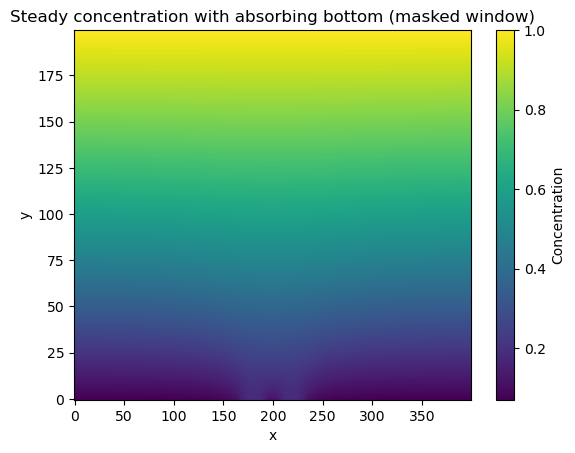

In [105]:

plt.imshow(C.T, origin="lower", aspect="auto")
plt.colorbar(label="Concentration")
plt.title("Steady concentration with absorbing bottom (masked window)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

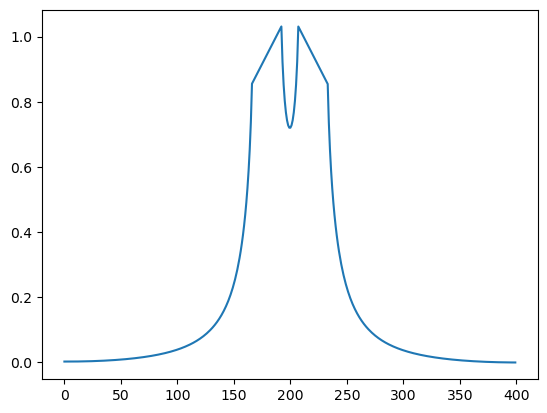

In [106]:

background_value = np.min(C[:, 0])
extra_thickness = C[:, 0] - background_value #+ 1e-6
normalized_thickness = extra_thickness/ background_value

plt.plot(np.arange(nx)[non_absorb_mask == 0], normalized_thickness[non_absorb_mask == 0])

In [61]:
def _single_run(absorption_rate):

    absorption_coefficient = 1/absorption_rate

    C, iters, maxchange = solve_core(nx, ny, C0, absorption_rate, non_absorb_mask, tol=1e-5, max_iter=20000, omega=1.2)

    return C[:, 0], C[0, :]


def parameter_sweep_parallel(num, n_jobs=2, backend="loky"):
    a = np.linspace(-3.5, -0.5, num = num, endpoint = True)
    absorption_rates = np.power(10, a)

    print(absorption_rates)

    results = Parallel(n_jobs=n_jobs, backend=backend)(
        delayed(_single_run)(absorption_rate)
        for absorption_rate in absorption_rates
    )

    thickness_bottom, thickness_left = zip(*results)
    return absorption_rates, thickness_bottom, thickness_left

In [71]:
absorption_rates, thickness_bottom, concentration_left = parameter_sweep_parallel(num = 10, n_jobs=-1, backend="loky")

[0.00031623 0.00068129 0.0014678  0.00316228 0.00681292 0.01467799
 0.03162278 0.06812921 0.14677993 0.31622777]


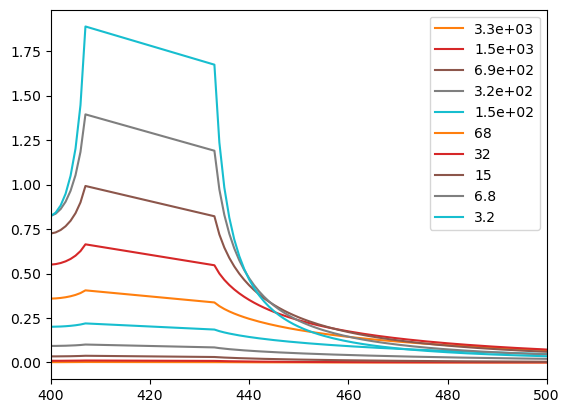

In [92]:
#print(absorption_rates)

for i in range(10):
    background_value = np.min(thickness_bottom[i])
    extra_thickness = thickness_bottom[i] - background_value #+ 1e-6
    normalized_thickness = extra_thickness/ background_value


    slope = concentration_left[i][1]-concentration_left[i][0]

    plt.plot(np.arange(50), np.arange(50)*slope + concentration_left[i][0])

    measured_absorption = slope/concentration_left[i][0]

    plt.plot(np.arange(nx)[non_absorb_mask == 0], normalized_thickness[non_absorb_mask == 0], label=f"{1/measured_absorption:.2g}")

plt.xlim(nx//2, nx//2 + 100)
#plt.yscale('log')
plt.legend()

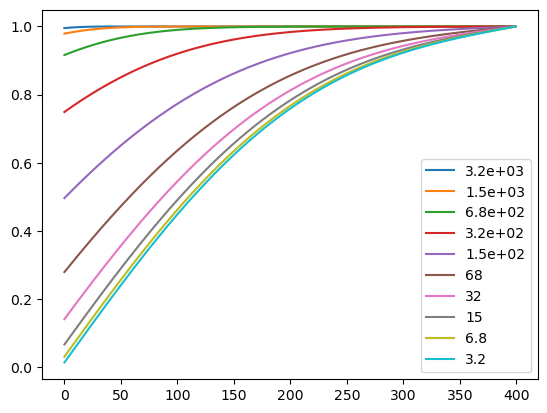

In [90]:
for i in range(10):
    plt.plot(concentration_left[i], label=f"{1/absorption_rates[i]:.2g}")

plt.legend()

0.006794283568126186
147.18255279942528


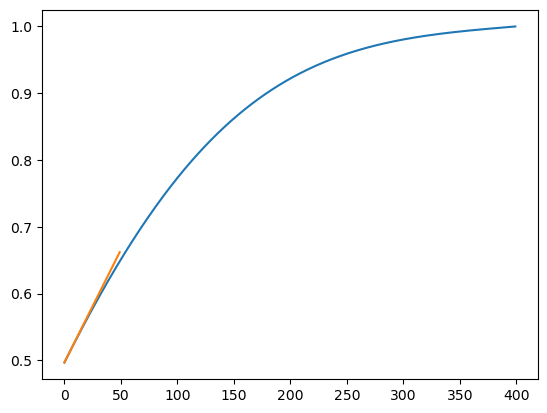

In [80]:
plt.plot(concentration_left[4])

slope = concentration_left[4][1]-concentration_left[4][0]

plt.plot(np.arange(50), np.arange(50)*slope + concentration_left[4][0])

measured_absorption = slope/concentration_left[4][0]

print(measured_absorption)
print(1/measured_absorption)